In [1]:
from sklearn.svm import SVR
import numpy as np
from datetime import datetime
import pandas as pd  
import matplotlib.pyplot as plt 
from pandas import DataFrame 
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('./data/BVH_2015.csv')
close_colunm_name = 'close'
df = df.set_index(pd.DatetimeIndex(df['date'].values))
df = df[[close_colunm_name]]
time_steps = 10
test_start_idx = int(df.shape[0] * 0.9)
test_start_date = (df.index.values[test_start_idx])
df.shape[0]


1955

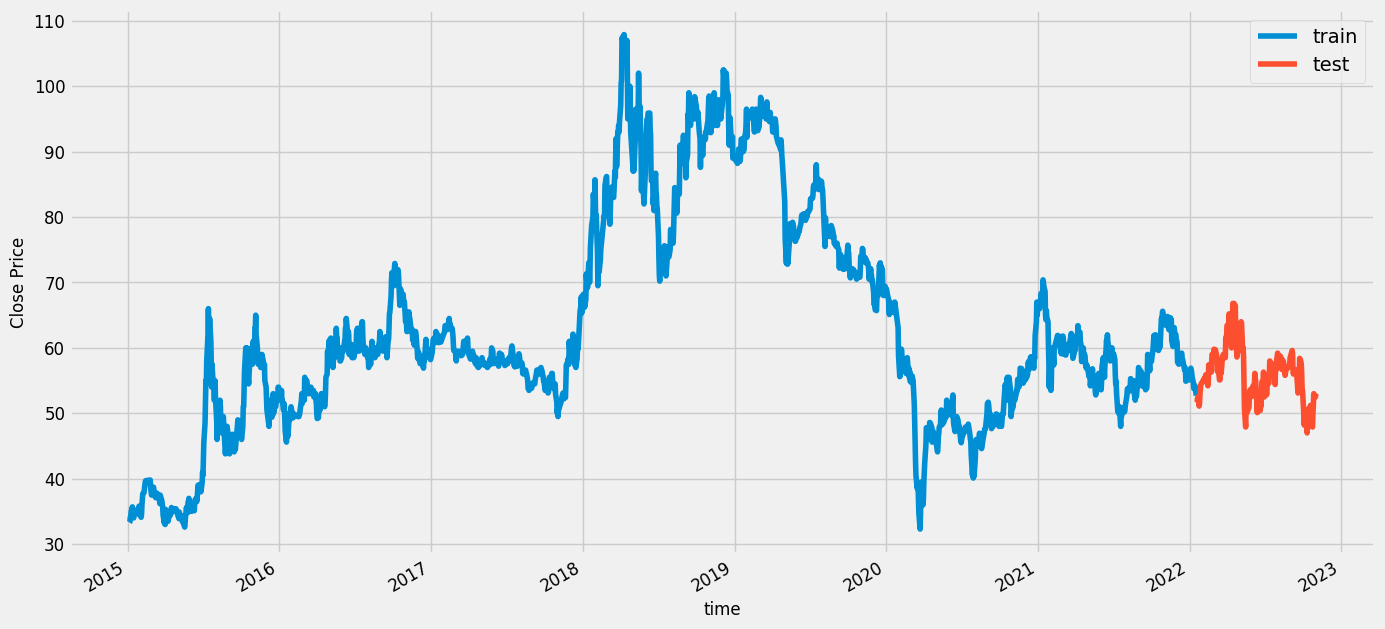

In [3]:
#Visualize the differences
df[df.index < test_start_date][[close_colunm_name]].rename(columns={close_colunm_name: 'train'})\
            .join(df[test_start_date:][[close_colunm_name]].rename(columns={close_colunm_name: 'test'}), how='outer')\
            .plot(y = ['train', 'test'], figsize=(15,8), fontsize=12)
plt.xlabel('time', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.show()

In [4]:
# Create train and test dataset
train = df.copy()[df.index < test_start_date][[close_colunm_name]]
test = df.copy()[test_start_date:][[close_colunm_name]]
print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1759, 1)
Test data shape:  (196, 1)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train[close_colunm_name] = scaler.fit_transform(train)
test[close_colunm_name] = scaler.fit_transform(test)

In [6]:
#Create data with time_steps
train_data = train.values
test_data = test.values

In [7]:
train_data_timesteps=np.array([[j for j in train_data[i:i+time_steps]] for i in range(0,len(train_data)-time_steps+1)])[:,:,0]
train_data_timesteps.shape

(1750, 10)

In [8]:
test_data_timesteps=np.array([[j for j in test_data[i:i+time_steps]] for i in range(0,len(test_data)-time_steps+1)])[:,:,0]
test_data_timesteps.shape

(187, 10)

In [9]:
x_train, y_train = train_data_timesteps[:,:time_steps-1],train_data_timesteps[:,[time_steps-1]]
x_test, y_test = test_data_timesteps[:,:time_steps-1],test_data_timesteps[:,[time_steps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_test)

(1750, 9) (1750, 1)
(187, 9) (187, 1)
[[-1.06756781 -1.04323295 -0.89722379 ... -0.72687977 -0.5322009
  -0.38619174]
 [-1.04323295 -0.89722379 -0.84855407 ... -0.5322009  -0.38619174
  -0.11850828]
 [-0.89722379 -0.84855407 -1.1892421  ... -0.38619174 -0.11850828
  -0.14284314]
 ...
 [-1.28658154 -1.23791182 -1.16490724 ... -1.45692556 -1.16490724
  -0.72687977]
 [-1.23791182 -1.16490724 -1.21357696 ... -1.16490724 -0.72687977
  -0.84855407]
 [-1.16490724 -1.21357696 -1.93145532 ... -0.72687977 -0.84855407
  -0.84855407]]


In [10]:
#Create and train a SVR model using a linear kernel
linear_SVR = SVR(kernel = 'linear', C = 1000.0)
linear_SVR.fit(x_train, y_train[:,0])

#Create and train a SVR model using a polynomial kernel
polynomial_SVR = SVR(kernel = 'poly', C = 1000.0, degree = 2)
polynomial_SVR.fit(x_train, y_train[:,0])

#Create and train a SVR model using a rbf kernel
rbf_SVR = SVR(kernel = 'rbf', C = 1000.0, gamma = 0.5)
rbf_SVR.fit(x_train, y_train[:,0])

SVR(C=1000.0, gamma=0.5)

In [11]:
#Make models predicttions
y_train_linear_SVR_prediction = linear_SVR.predict(x_train).reshape(-1,1)
y_test_linear_SVR_prediction = linear_SVR.predict(x_test).reshape(-1,1)

y_train_polynomial_SVR_prediction = polynomial_SVR.predict(x_train).reshape(-1,1)
y_test_polynomial_SVR_prediction = polynomial_SVR.predict(x_test).reshape(-1,1)

y_train_rbf_SVR_prediction = rbf_SVR.predict(x_train).reshape(-1,1)
y_test_rbf_SVR_prediction = rbf_SVR.predict(x_test).reshape(-1,1)

In [12]:
#Scaling the predictions
y_train_linear_SVR_prediction = scaler.inverse_transform(y_train_linear_SVR_prediction)
y_test_linear_SVR_prediction = scaler.inverse_transform(y_test_linear_SVR_prediction)

y_train_polynomial_SVR_prediction = scaler.inverse_transform(y_train_polynomial_SVR_prediction)
y_test_polynomial_SVR_prediction = scaler.inverse_transform(y_test_polynomial_SVR_prediction)

y_train_rbf_SVR_prediction = scaler.inverse_transform(y_train_rbf_SVR_prediction)
y_test_rbf_SVR_prediction = scaler.inverse_transform(y_test_rbf_SVR_prediction)

In [13]:
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
print(y_train)

[[49.00447256]
 [48.95425094]
 [49.00447256]
 ...
 [53.77552576]
 [53.82574738]
 [53.44908528]]


In [14]:
# Check model performance on training and testing data
train_timestamps = df[df.index < test_start_date].index[time_steps-1:]
test_timestamps = df[test_start_date:].index[time_steps-1:]

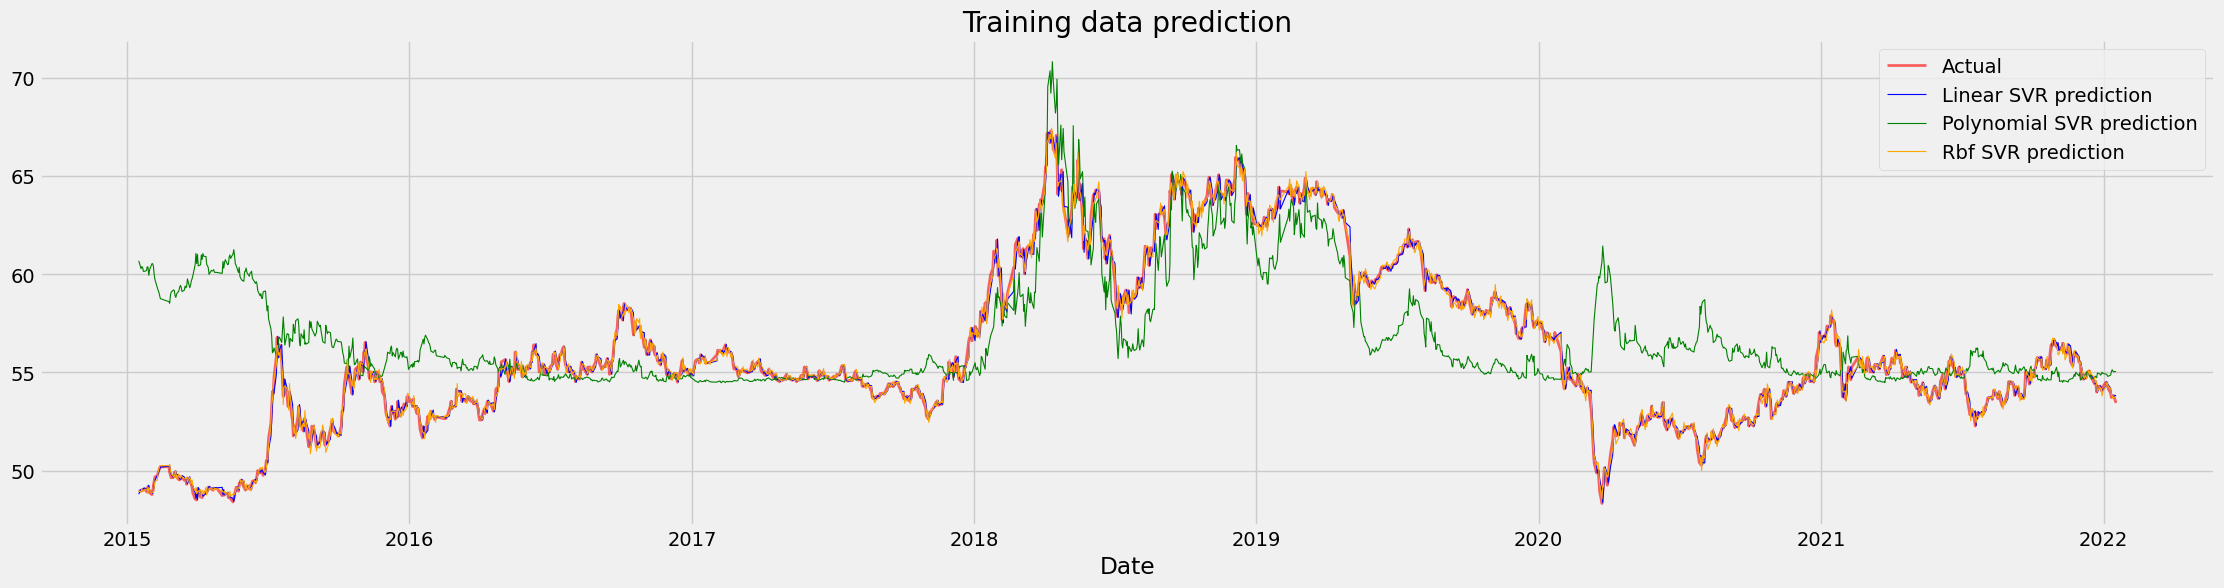

In [15]:
#plot the predictions for training data
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_linear_SVR_prediction, color = 'blue', linewidth=0.8)
plt.plot(train_timestamps, y_train_polynomial_SVR_prediction, color = 'green', linewidth=0.8)
plt.plot(train_timestamps, y_train_rbf_SVR_prediction, color = 'orange', linewidth=0.8)
plt.legend(['Actual','Linear SVR prediction','Polynomial SVR prediction','Rbf SVR prediction'])
plt.xlabel('Date')
plt.title("Training data prediction")
plt.show()

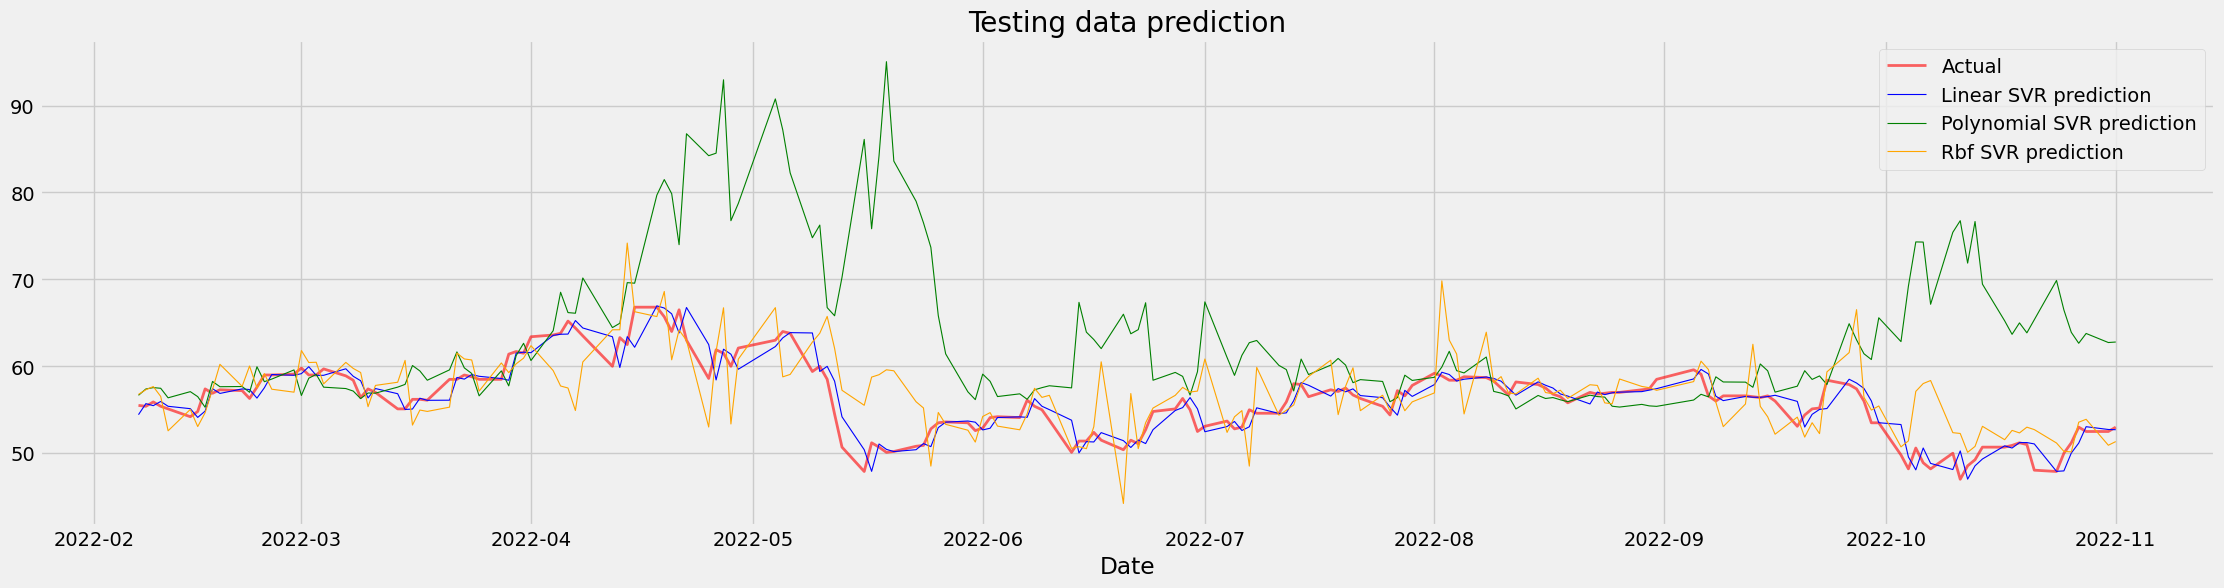

In [16]:
#plot the predictions for testing data
plt.figure(figsize=(25,6))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_linear_SVR_prediction, color = 'blue', linewidth=0.8)
plt.plot(test_timestamps, y_test_polynomial_SVR_prediction, color = 'green', linewidth=0.8)
plt.plot(test_timestamps, y_test_rbf_SVR_prediction, color = 'orange', linewidth=0.8)
plt.legend(['Actual','Linear SVR prediction','Polynomial SVR prediction','Rbf SVR prediction'])
plt.xlabel('Date')
plt.title("Testing data prediction")
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
print("MSE for linear SVR on testing data:",mean_squared_error(y_test,y_test_linear_SVR_prediction))
print("MSE for polinomial SVR on testing data:",mean_squared_error(y_test,y_test_polynomial_SVR_prediction))
print("MSE for RBF SVR on testing data:",mean_squared_error(y_test,y_test_rbf_SVR_prediction))

MSE for linear SVR on testing data: 2.198542954785493
MSE for polinomial SVR on testing data: 138.74899004524542
MSE for RBF SVR on testing data: 13.327801317494595


In [18]:
from sklearn.metrics import mean_absolute_percentage_error
print("MAPE for linear SVR on testing data:",mean_absolute_percentage_error(y_test,y_test_linear_SVR_prediction))
print("MAPE for polinomial SVR on testing data:",mean_absolute_percentage_error(y_test,y_test_polynomial_SVR_prediction))
print("MAPE for RBF SVR on testing data:",mean_absolute_percentage_error(y_test,y_test_rbf_SVR_prediction))

MAPE for linear SVR on testing data: 0.018941180448409863
MAPE for polinomial SVR on testing data: 0.1428991015818376
MAPE for RBF SVR on testing data: 0.048327449785423436


In [19]:
from sklearn.metrics import mean_absolute_error
print("MAE for linear SVR on testing data:",mean_absolute_error(y_test,y_test_linear_SVR_prediction))
print("MAE for polinomial SVR on testing data:",mean_absolute_error(y_test,y_test_polynomial_SVR_prediction))
print("MAE for RBF SVR on testing data:",mean_absolute_error(y_test,y_test_rbf_SVR_prediction))

MAE for linear SVR on testing data: 1.056863498597144
MAE for polinomial SVR on testing data: 7.679369652904788
MAE for RBF SVR on testing data: 2.6792516501993466
